# ⚽ 2026 World Cup Readiness Framework - Exploratory Data Analysis

**Team:** XOH (Soomi Oh, Yoo Mi Oh)

**Date:** 25th February, 2026  

**For Complete Report:** See `EDA_midterm_xoh.ipynb`

---

## 1. Executive Summary

### 1.1 Project Objective

Predicting 2026 World Cup performance requires moving beyond FIFA rankings and recent 
results to answer three interconnected questions simultaneously:

**1. Individual Quality:** Who are the players, how reliable is their output, and are 
they performing at their peak entering 2026?

**2. Tactical Identity:** What kind of team do they form, how consistent is that identity 
under tournament pressure, and which archetype does the data actually confirm?

**3. Contextual Fit:** How do host advantage, confederation travel, managerial stability, 
and club cohesion shape a squad's probability of deep tournament progression?

To answer these questions, we are building a **three-layer analytical system** grounded 
in StatsBomb open event and 360 spatial tracking data:

- **Layer 1 — Tactical DNA:** 8 team dimensions aggregated from 2022 and 2024 major 
tournaments, capturing collective behaviour across pressing, possession, progression, 
territorial dominance, and defensive structure
- **Layer 2 — Player Quality:** 12 player dimensions spanning 2021–2025, time-decay 
weighted to prioritise recent form, evaluated within positional archetypes rather than 
on a universal composite scale
- **Layer 3 — Readiness Score:** A single auditable score per nation synthesising 
tactical identity and player quality with contextual adjustment factors

### 1.2 Scope of This Executive Report

This midterm report covers the first two phases of the project: raw data validation and 
metric engineering. Specifically, this notebook walks through:

**1. Dataset Overview:** the structure, scale, and temporal distribution of the 
StatsBomb open data, and the key decisions that shaped the pipeline's scope

**2. Data Processing Strategy:** how 12.2M raw events and 15,584,040 frames of 360 
spatial tracking data are transformed into the 8 tactical and 12 player quality 
dimensions via DuckDB, Polars, and Pandas

**3. Initial EDA Findings:** surprising structural discoveries from the raw data that 
directly informed pipeline architecture decisions

**4. Metric Framework Overview:** validation, distribution analysis, and correlation 
audits for both the 8 tactical dimensions and 12 player quality metrics, with key 
modeling implications documented for each

Both evidence streams are now validated, documented, and pipeline-ready. The remaining 
phases — tactical clustering, player quality scoring, and the Readiness Score synthesis 
— will be delivered in the final report.

> For full methodology, intermediate experiments, and supporting visualizations, 
> see the complete `EDA_midterm_xoh.ipynb` notebook.

## 2. Data Retrieval

### 2.1 Data Sources

We use the **StatsBomb Open Data** dataset, accessed via the official template repository 
scripts:

| Dataset | Records | Coverage | Key Metrics |
|---------|---------|----------|-------------|
| **Matches** | 3,464 matches | 21 competitions, 1958-2025 | Competition, temporal, outcomes |
| **Events** | 12.2M events | 35 event types, 99.25% location | Tactical actions, xG, passes |
| **Lineups** | 165,820 records | 10,808 players, 25 positions | Player pool, participation |
| **360° Tracking** | 15.6M records | 323 matches (9.3%) | Spatial data (limited) |

### 2.2 Processing Architecture

Raw data is merely potential. To convert these four disparate datasets into the 8 
tactical dimensions and 12 player quality metrics that power the prediction model, we 
built a purpose-designed processing pipeline with two core components.

To handle the scale of the data, we utilise **DuckDB** — an in-process analytical 
database that enables SQL-based aggregation directly over Parquet files. This approach 
bypasses the memory overhead of loading the full 12.2M row event dataset into memory, 
ensuring high analytical throughput without sacrificing reproducibility. Where 
in-memory transformation is required, the pipeline employs a **hybrid Pandas / Polars 
architecture** — Polars for high-performance lazy evaluation and multi-threaded 
aggregation across large season-level files, Pandas for compatibility with visualisation 
and statistical libraries in the EDA layer. This combination optimises both computational 
efficiency and analytical flexibility across the pipeline.

The pipeline is orchestrated via a centralised entry point, `run_metrics.py`, which 
executes all metric computations in sequence and outputs results to a structured 
`/processed` directory. By isolating each scope (tournament or season folder) and metric 
(individual file), the pipeline remains **efficient, reproducible, and auditable** — 
a prerequisite for downstream consumption by both the player quality engine and the 
tactical clustering system.

The output of this pipeline is two validated evidence streams:
- **8 team tactical dimensions** aggregated at match and tournament level from 2022-2024 
major international tournaments
- **12 player quality dimensions** aggregated at player-season level across the 
2021-2025 rolling window, time-decay weighted to prioritise recent form

---

## 3. General Dataset Overview

### 3.1 Match Data: Temporal Distribution & The Case for Recency

#### Dataset at a Glance
- **3,464 matches** across 21 competitions
- **Temporal:** 54% concentrated in 2015-2016 (1,860 matches. Pre-2015: 425 scattered matches. Post-2016: 1,179 matches over 8 years.
- **Competitions:** La Liga 25%, Ligue 1 13%, Premier League 12%, Serie A 11%, Bundesliga 10%, Women's football 9.4%.
- **Outcomes:** 45.2% home wins, 23.0% draws, 31.8% away wins. 2.85 goals/match average.
- **Quality:** No duplicate IDs. Missing data limited to non-essential fields.

The longitudinal dataset spans 1958-2025 but its distribution reveals three distinct 
phases that directly shape the pipeline's temporal scope:

**1. The Legacy Spike (2015-2016):** The dataset peaks at ~1,800 matches, driven by early 
StatsBomb data releases rather than genuine match volume growth. With 748 matches 
originating from a single La Liga era, integrating this period would over-index the 
model on high-volume, low-tempo possession metrics a decade removed from the current 
gam, and render benchmarks structurally obsolete through regime decay. This is the 
period the pipeline explicitly excludes.

**2. The Sparsity Canyon (2017-2020):** Following the 2016 peak, the dataset enters a 
period of extreme thinness, nsufficient volume and compositional diversity to anchor 
reliable tactical benchmarks for 2026 projection.

**3. The Modern Meta (2021-2025):** Post-2021 data volume recovers with a fundamentally 
different compositional profile. Unlike the league-heavy 2015 era, this window is 
weighted toward international tournaments (including 2022 FIFA World Cup, and 2024 UEFA Euro and AFCON), environments that most directly simulate 
2026 conditions and act as the primary meta-shifters of global tactics.

By identifying the Legacy Spike as a structural artifact and the 2017-2020 gap as a 
loss of statistical signal, the mandate is clear: **the 2021-2025 window is the only 
valid blueprint for 2026.** The pipeline trades the comfort of 2015's raw volume for 
the accuracy of the current tournament-heavy, high-intensity meta.

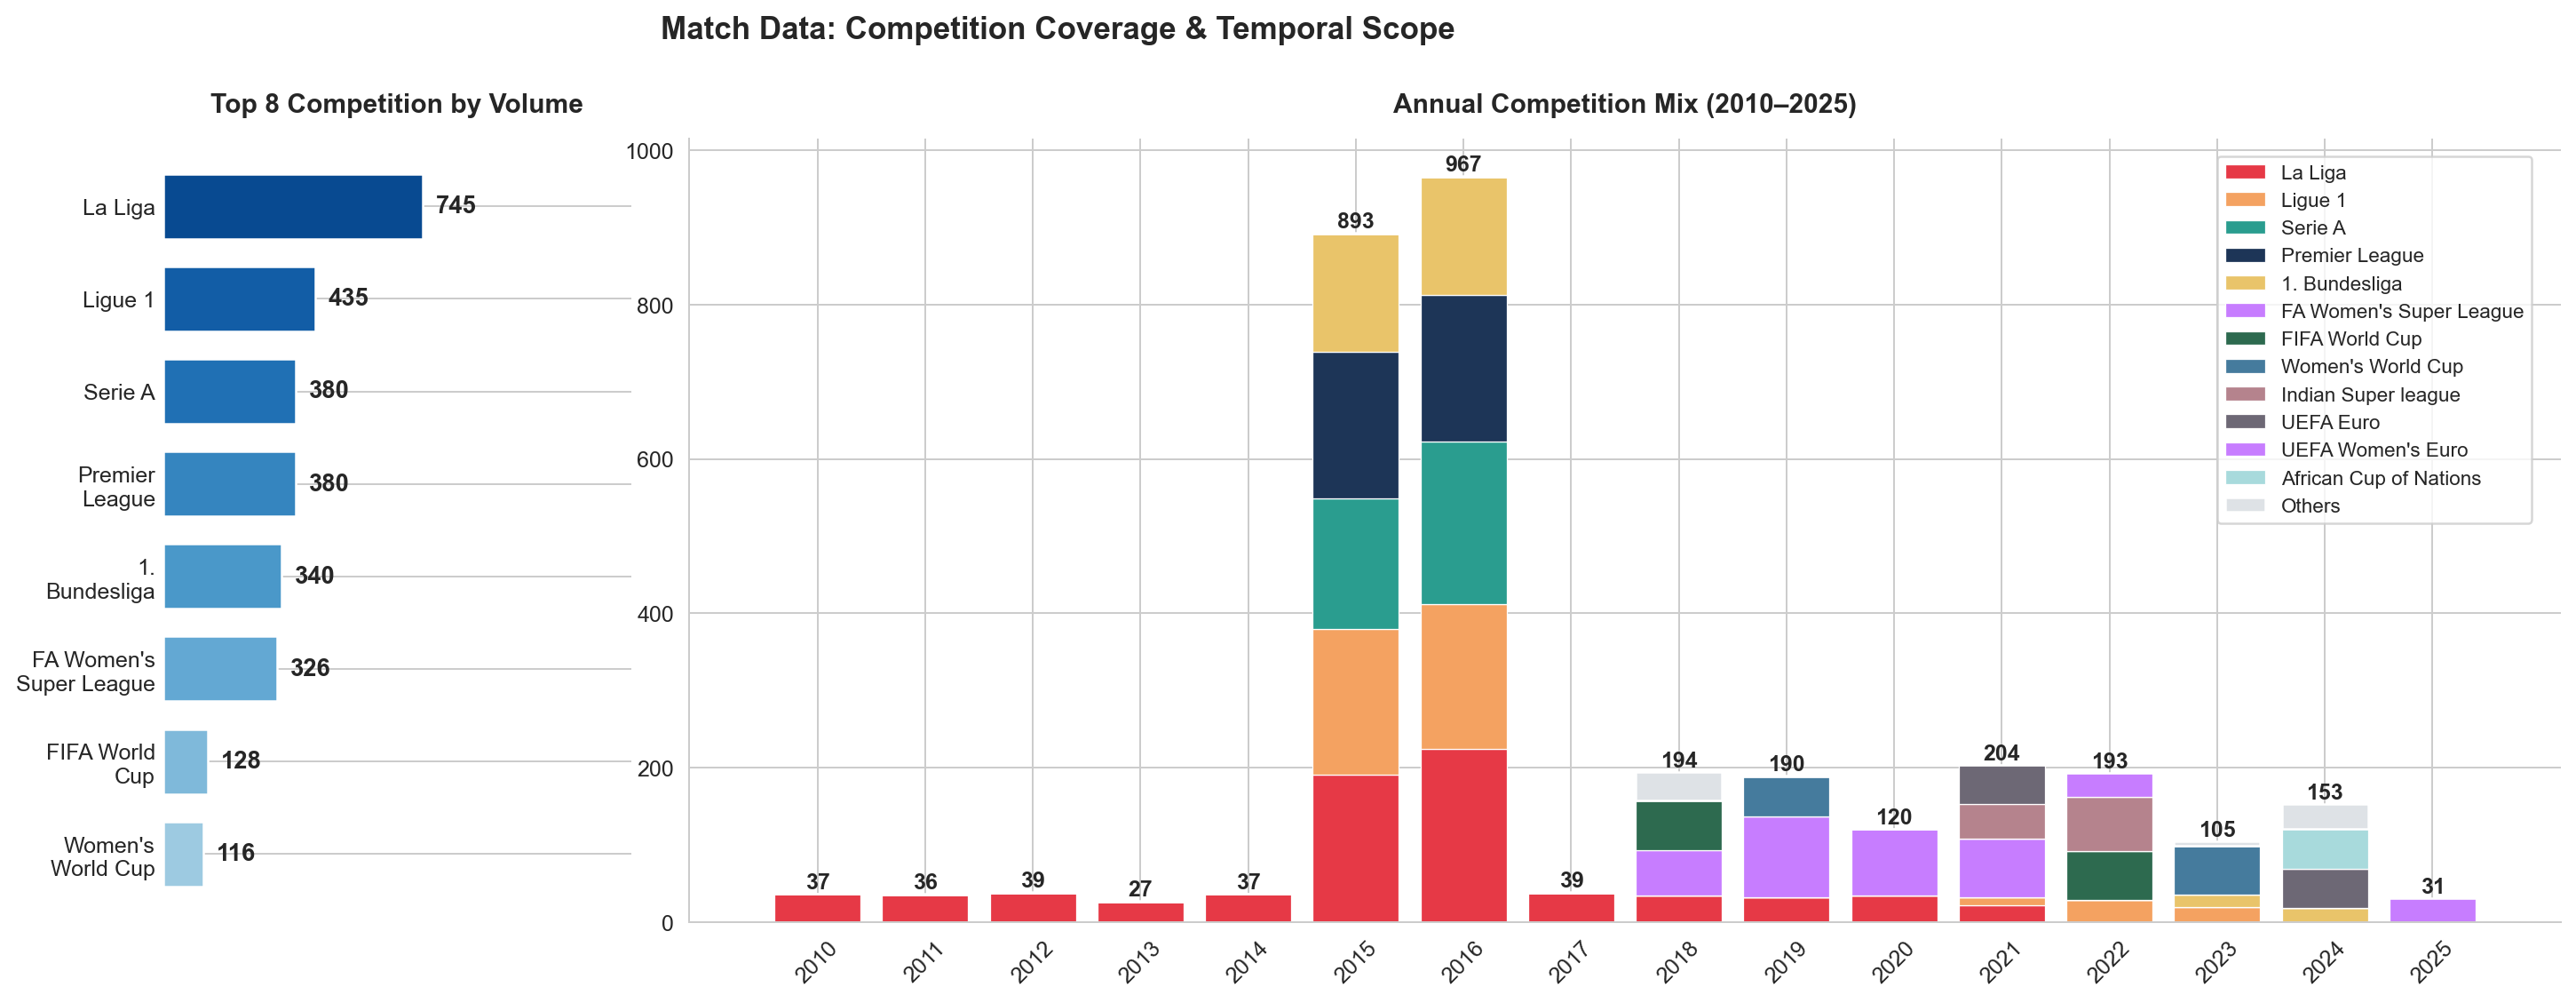

In [5]:
from IPython.display import Image, display
display(Image(filename='figures/matches_overview.png'), width=300)

### 3.2 Event Data: The Pulse of the Game

#### Dataset at a Glance
- **12,188,949 events** across 3,464 matches
- **Distribution:** Pass 27.8%, Ball Receipt 26.0%, Carry 21.6%, Pressure 9.1%, Shot 0.7%
- **Barcelona bias:** 10.2% of all events. Top 10 players all Barcelona 2010s (Messi, Busquets, Xavi, Iniesta).
- **Shot quality:** 9,383 total xG across 88,023 shots (0.107 avg). Only 8.1% qualify as big chances (xG > 0.3). Median 0.055 suggests many speculative efforts.
- **Passes:** 77.7% completion rate
- **Temporal:** 50.4% first half, 49.2% second half
- **Quality:** No duplicate IDs. 99.25% have location data. 20.9% under pressure.

The StatsBomb event dataset contains **12.2M discrete actions across 3,464 matches**, 
averaging 3,519 events per game across 35 unique event types. Unlike synchronous GPS 
tracking data, which records spatial coordinates alone, event-stream data captures 
**player agency and tactical decision-making** — encoding not just where a player is, 
but what they chose to do and why.

The distribution is heavily weighted toward high-leverage tactical actions:

**1. Progression & Possession (49.4%):** Passes (27.8%) and Carries (21.6%) form the 
backbone of the dataset, providing dense coverage of build-up phases and zone-to-zone 
transitions across all defensive structures.

**2. Defensive Intensity (12%):** Pressures (9.1%), Interceptions, and Clearances 
quantify defensive proactivity, encoding the high-press DNA of modern football in a 
way that GPS tracking data often fails to capture.

**3. Shooting (0.7%):** Low in volume but structurally sufficient. Shots are rare events 
in elite football, and the dataset's xG annotations provide the finishing and threat 
generation signal required for both team and player-level metrics.

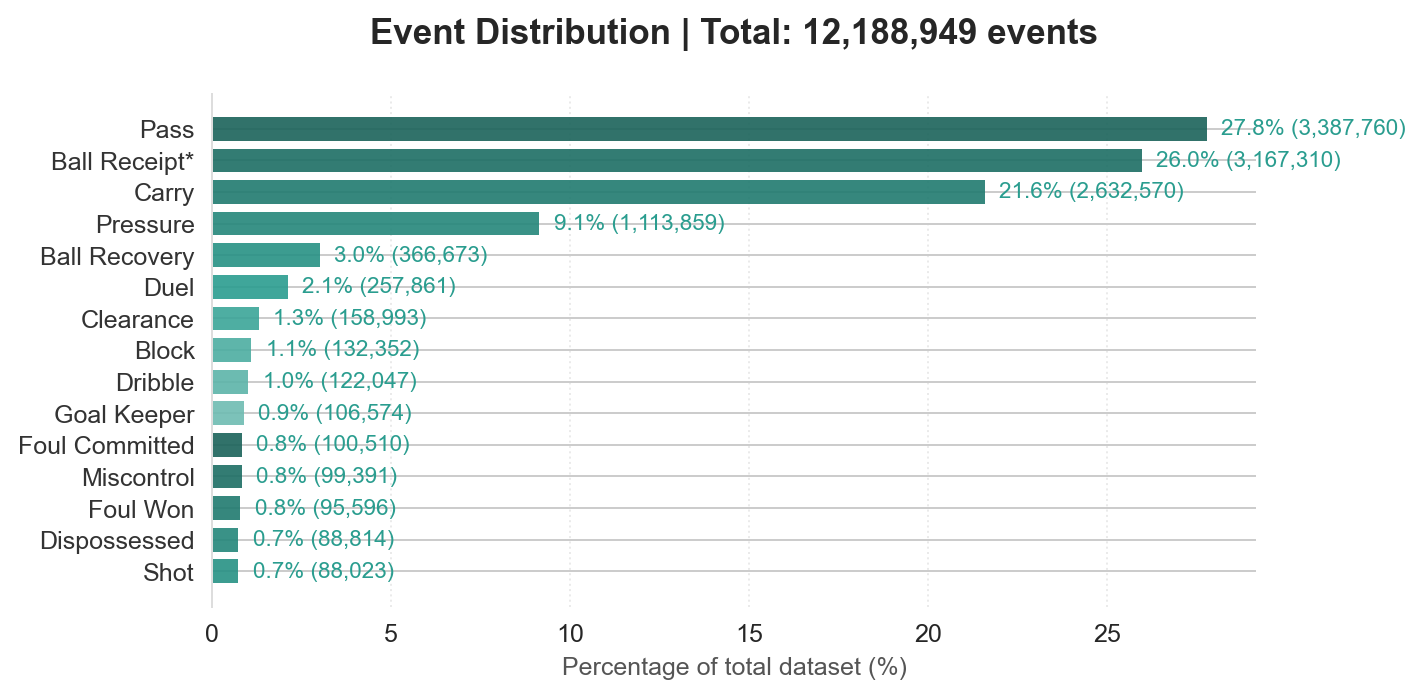

In [11]:
display(Image(filename='figures/event_type_dis.png'), width=100)

### 3.3 Lineup Data: Who Was on the Pitch
#### Dataset at a Glance
- **165,820 entries** across 3,464 matches with 10,808 unique players identified.
- **Participation:** 58.3% of the recorded lineup entries actually saw game time (96,698 players/instances).
- **Substitutions:** 5.9 avg per match. Starters averaged 84.7 min, while substitutes averaged 21.5 min of playing time.
- **Playing Time:** 55.8% played 90+ min, 18.5% played 60-90 min, 9.0% played 30-60 min, and 16.7% played under 30 min.
- **Cards:** 19,606 total cards (11.8% of records). 96.5% were Yellow Cards. Sergio Busquets leads the disciplinary table with 130 cards.
- **Quality:** 60,491 duplicate (match_id, player_id) pairs detected (36.5%), representing significant tactical flexibility and position changes during matches.

#### The Functional Player Profile
The lineup dataset comprises 165,820 entries across 10,808 unique players, but raw 
participation data requires three structural corrections before it can inform reliable 
2026 projections:

- **The Super-Sub Trap:** Starters average 84.7 minutes versus 21.5 minutes for 
substitutes. Evaluating both on a pure per-90 basis creates an artificial performance 
ceiling; a 10-minute cameo against a fatigued defence produces "elite" metrics that 
are physically unsustainable across a full match. A **270-minute minimum threshold** 
filters for foundation players with proven tactical consistency.

- **Disciplinary Risk:** 19,606 cards recorded (11.8% of entries) provide a 
high-resolution disciplinary profile per player, an input for suspension risk 
forecasting across the condensed 48-team tournament schedule.

- **The Position Paradox:** 60,491 duplicate player-match pairs (36.5%) reflect 
mid-game structural shifts rather than data errors. A **minutes-weighted primary 
position** classification resolves this in which players are categorised by their dominant 
functional role across time-on-pitch rather than emergency tactical adjustments.

### 3.4 360° Data Strategy
#### Dataset at a Glance
- **15,584,040 frames**
- **Coverage:** Only 9.3% of matches (323/3,464)
- **Competitions:** Tournament-focused. UEFA Euro 100%, Women's Euro 95%, but only 10% Bundesliga. No La Liga/PL/Serie A coverage.
- **Temporal:** All 2020-2025, zero overlap with dense 2015-2016 period.
- **Frames:** 50% teammate, 6.6% actor, 2.3% keeper. All have location + visible area polygons.

The 360° data acts as a Modern Tactical North Star, defining elite performance standards despite its 9.3% scarcity compared to the broader longitudinal dataset. It serves as a high-fidelity standalone validation set, ensuring 2026 projections are calibrated against a high-resolution contemporary meta rather than being diluted by historical legacy volume.

## 4. Metric Framework Overview

#### Metric Framework Overview

The processing pipeline produces two distinct metric families — one capturing collective 
tactical behaviour at the team level, one capturing individual quality at the player 
level. Together they form the two evidence streams that feed the Readiness Score.

##### Team-Level Tactical Dimensions (8 Metrics)

| Dimension | Metric | Tactical Signal |
|-----------|--------|----------------|
| **Pressing Intensity** | PPDA (Passes Allowed Per Defensive Action) | How aggressively a team hunts the ball out of possession |
| **Territorial Control** | Field Tilt % | Share of total attacking actions occurring in the opponent's half |
| **Ball Retention** | Possession % | Share of total match possession |
| **Defensive Structure** | Defensive Line Height | Average depth of the defensive line in open play |
| **Progression Efficiency** | Progression Ratio | Ratio of progressive to total passes, capturing vertical intent |
| **Buildup Threat** | xG per Buildup Possession | Average expected goals generated per sustained possession sequence |
| **Finishing Output** | xG Totals (npxG) | Non-penalty expected goals; quality of chances created |
| **Possession Efficiency** | EPR (Efficiency-Possession Ratio) | Ratio of possession share to threat generated — identifies sterile dominance |

##### Player-Level Quality Dimensions (12 Metrics)

| Category | Metric | Quality Signal |
|----------|--------|---------------|
| **Final Third Output** | Goals − xG | Finishing quality relative to chance difficulty |
| **Final Third Output** | xG Volume | Total shooting volume and threat generation |
| **Final Third Output** | xG Chain p90 | Involvement in attacking sequences leading to chances |
| **Final Third Output** | Team Involvement % | Share of team's xG chains a player participates in |
| **Final Third Output** | xG Buildup p90 | Contribution to deeper buildup phases preceding chances |
| **Progression** | Progressive Passes p90 | Forward passing volume per 90 minutes |
| **Progression** | Progressive Carries p90 | Ball-carrying progression per 90 minutes |
| **Progression** | Avg Packing (360°) | Opposition players bypassed per pass; line-breaking quality |
| **Control** | Network Involvement % | Centrality in team passing network; structural hub influence |
| **Mobility & Intensity** | Pressures p90 | Pressing volume per 90 minutes |
| **Mobility & Intensity** | Pressure Success % | Rate of successful pressure events; pressing quality |
| **Mobility & Intensity** | Total Defensive Actions | Combined defensive contributions across all action types |

### 4.1 The Tactical Scatter Plot
The PPDA × Possession × npxG scatter confirms three structural findings that directly 
configure the clustering architecture:

- **The Winner Zone is real:** Argentina, England, Spain, and Germany cluster in the 
high-possession (57–65%), high-press (PPDA 6–10) top-left quadrant. Deep tournament 
runs concentrate here; Group Stage exits concentrate in the bottom-right.

- **Elite Pragmatists are a distinct tier:** France and Morocco both reached the Final 
and Semi-Final respectively from outside the Winner Zone (~13 PPDA), but through 
different mechanisms — France via elite individual chance creation (large npxG bubble), 
Morocco via defensive compactness (small bubble). They cannot be collapsed into generic 
defensive clusters.

- **npxG differentiates within clusters:** Bubble size varies significantly among teams 
sharing similar tactical coordinates, confirming npxG as the intra-cluster quality 
filter — separating teams that look tactically identical but differ in actual threat 
generation.

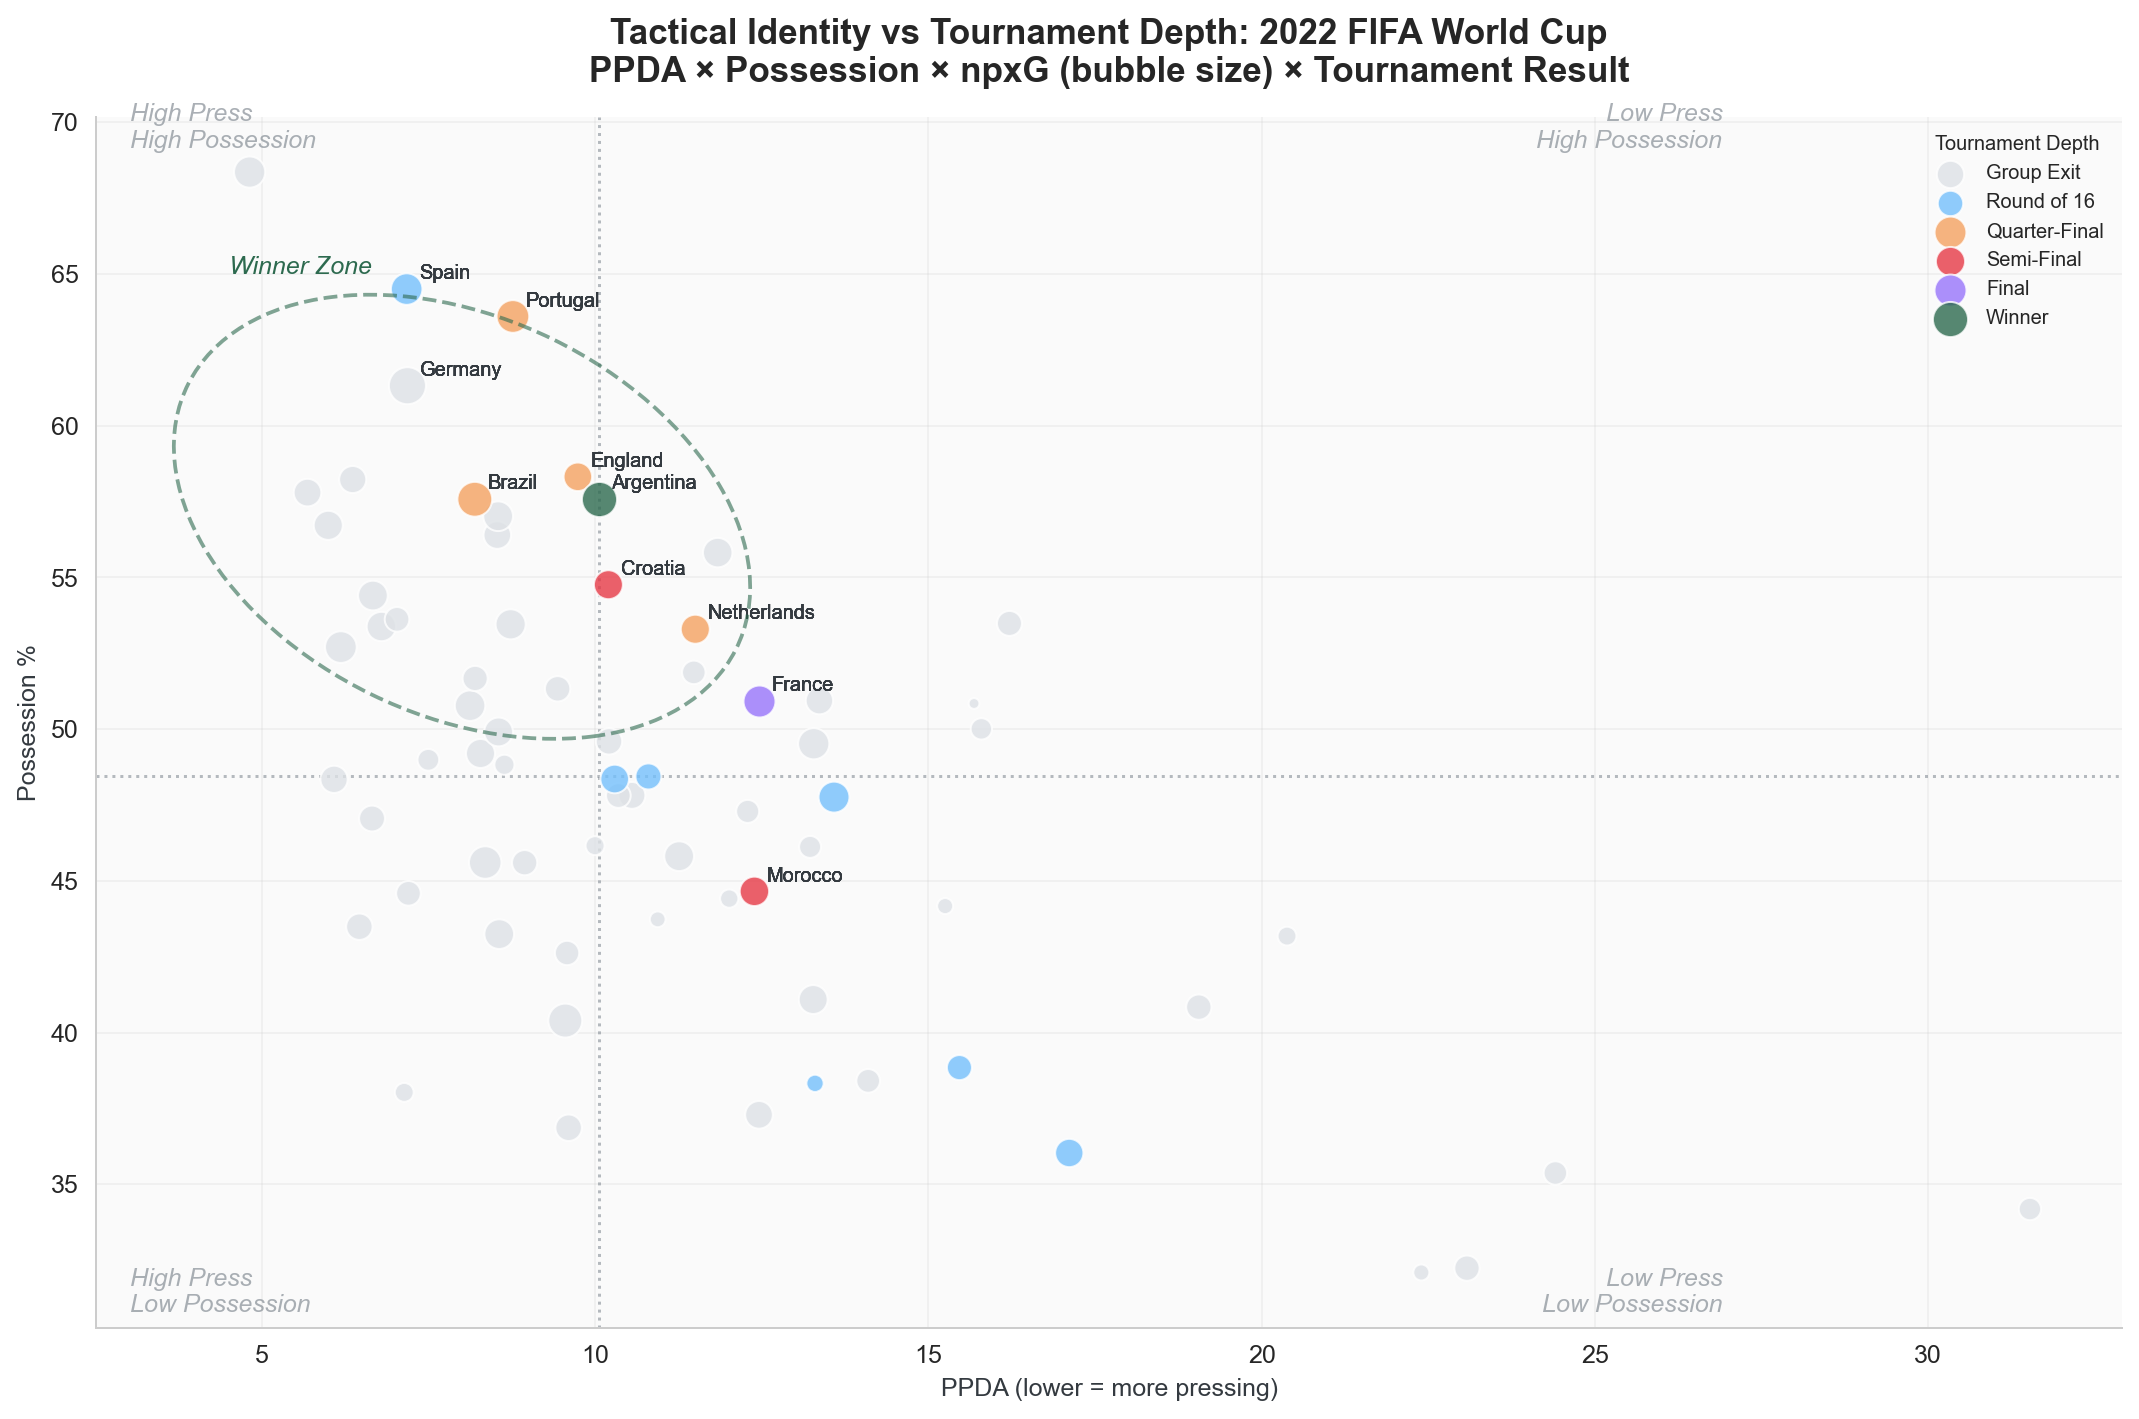

In [14]:
display(Image(filename='figures/tactical_scatter.png'))

### 4.2 The Player Metric Correlation Matrix

The correlation matrix confirms all 12 dimensions are non-redundant (maximum r = 0.63), 
with three findings directly shaping the scoring architecture:

- **Elite finishers are complete players:** Goals − xG correlates most strongly with 
xG Chain (0.63), Avg Packing (0.61), and Total Defensive Actions (0.61), confirming 
that finishing quality is systematically linked to attacking involvement, progression, 
and defensive contribution rather than being an isolated specialist skill.

- **Presence and danger are decoupled:** Team Involvement % is virtually uncorrelated 
with every other metric (max r = -0.08), confirming it captures a pure structural 
presence signal that no other dimension replicates, justifying its treatment as an 
independent feature rather than a proxy for attacking quality.

- **The Pressure Paradox:** Pressures p90 and Pressure Success % are negatively 
correlated (-0.10), confirming that pressing volume and pressing quality are opposing 
dimensions. High-volume pressers are marginally less efficient per press, and vice versa. Both metrics must be retained and scored independently.

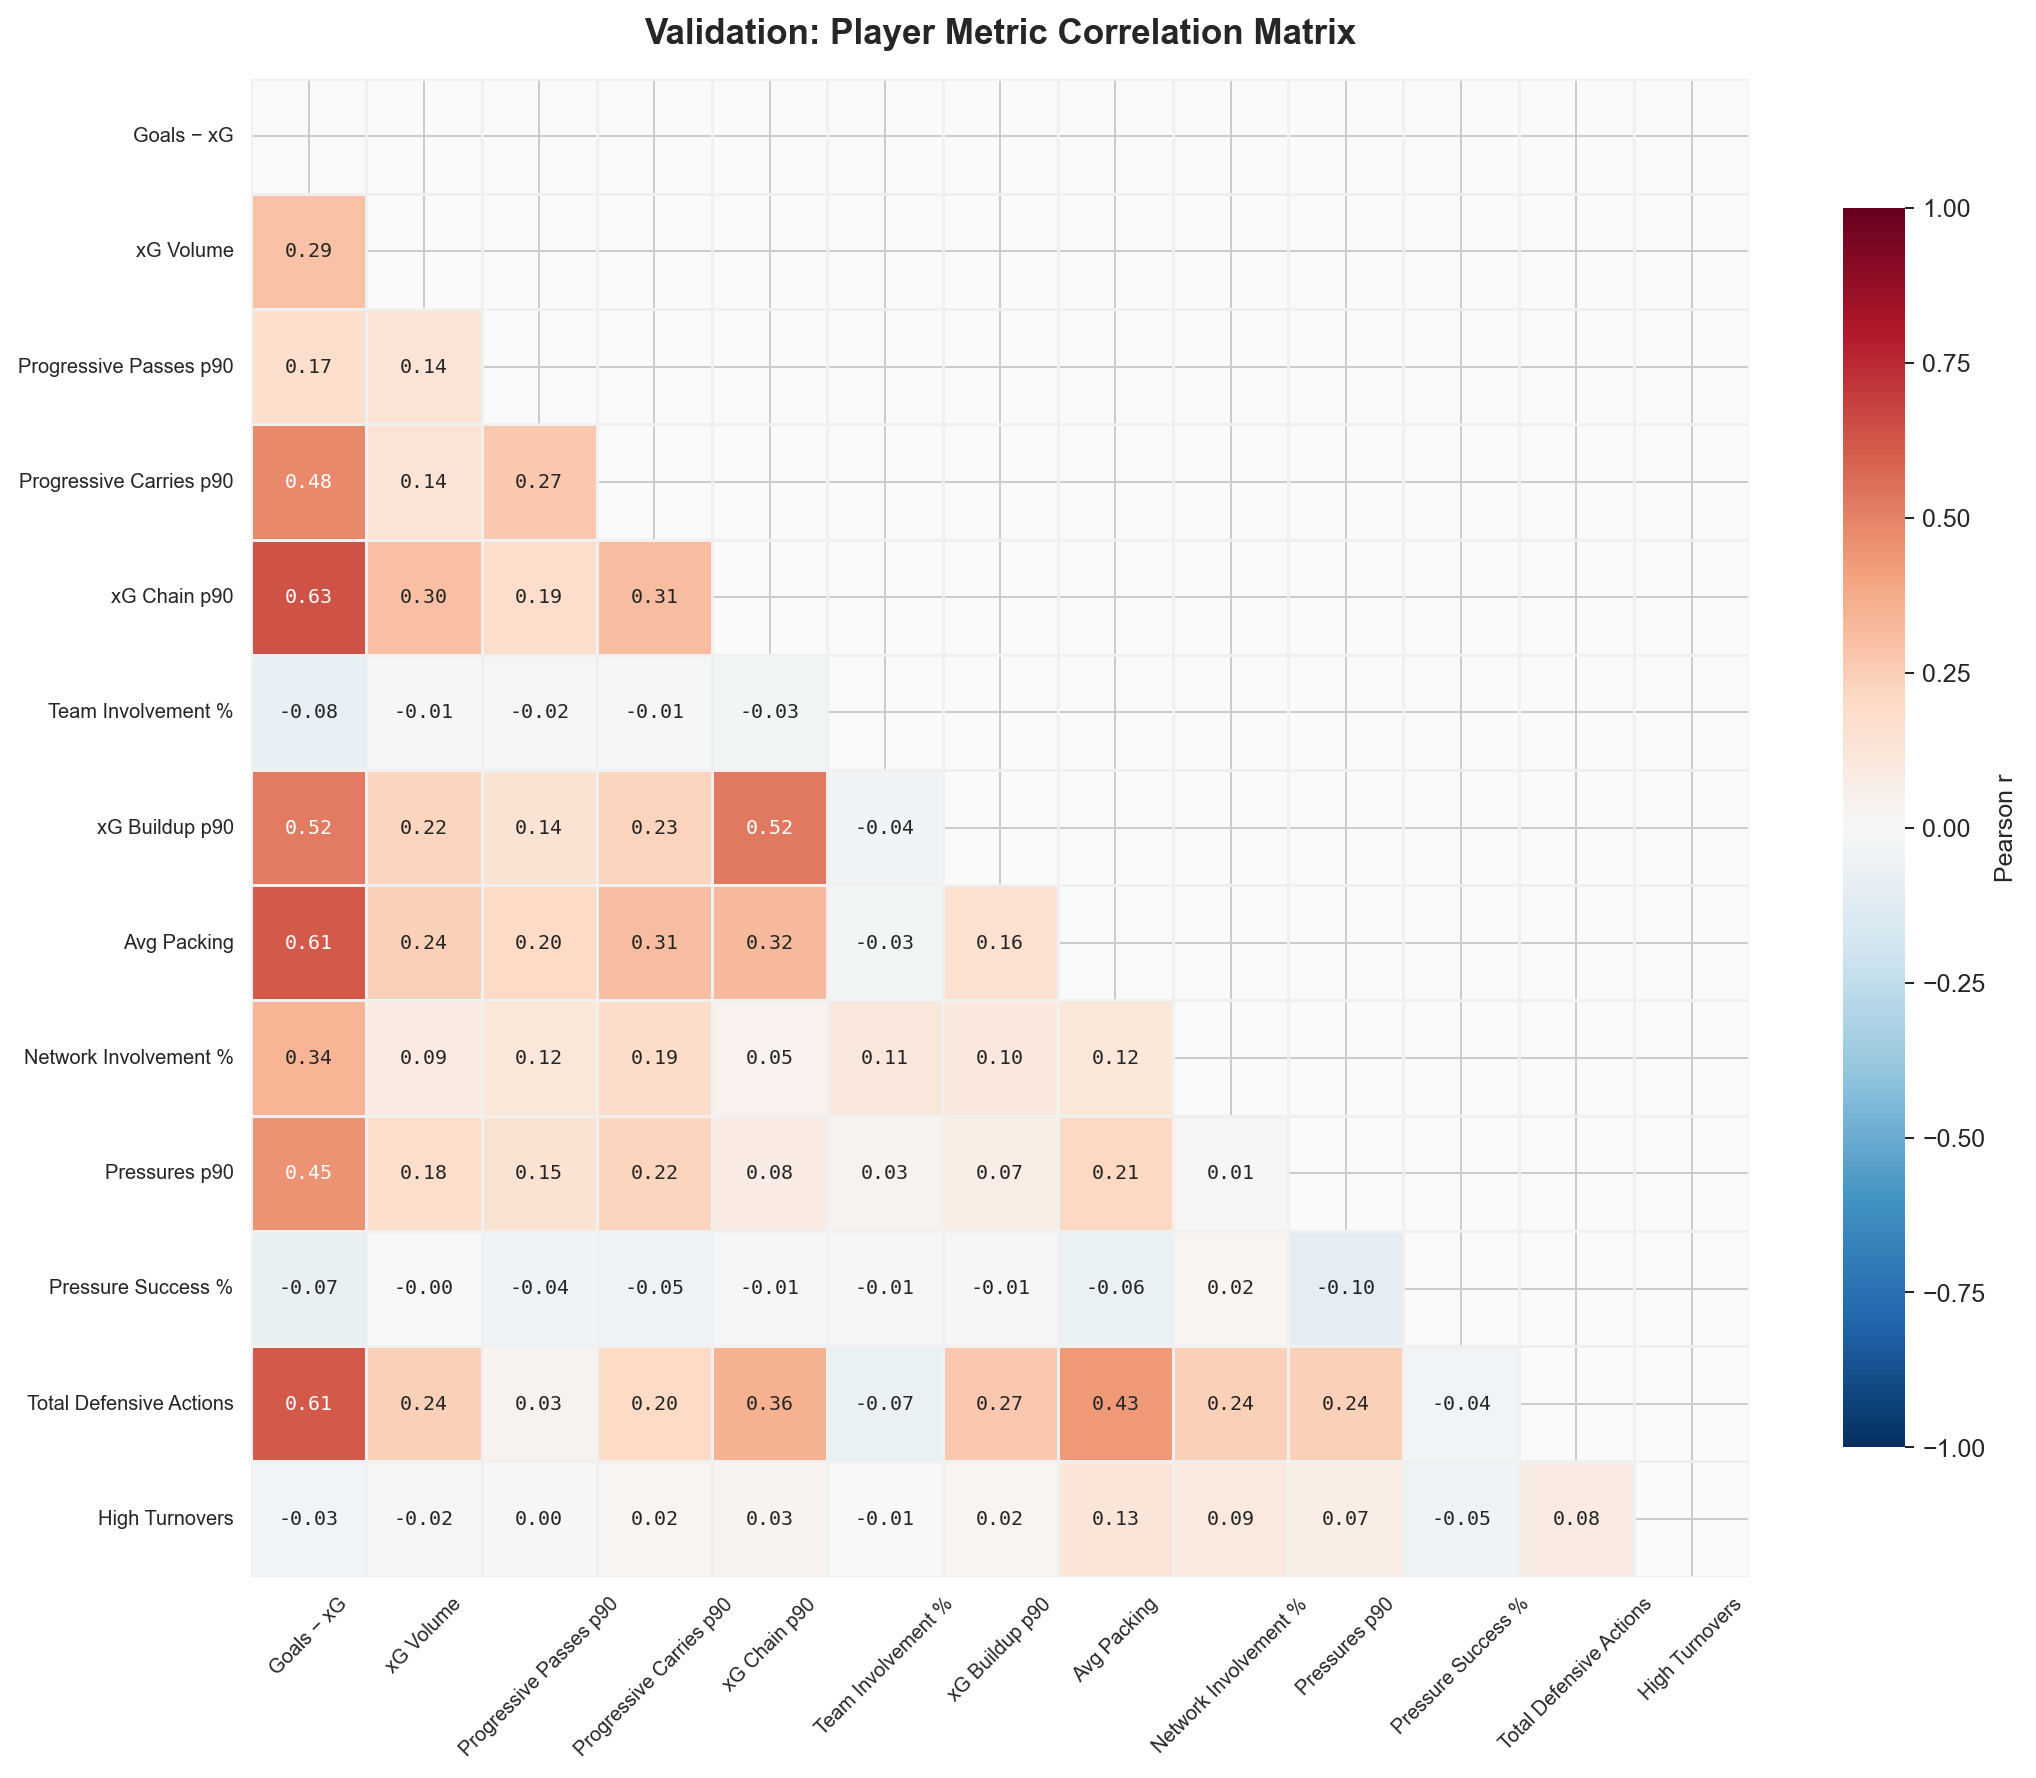

In [15]:
display(Image(filename='figures/player_metrics_corr.png'))

### Next Steps

With the metric engineering and exploratory analysis phases complete, the final report 
will deliver three remaining analytical components and one user-facing deliverable:

**1. Tactical Clustering:** K-Means architecture (k=4) classifying all 
48 qualified nations into empirically grounded archetypes, validated against historical 
tournament outcomes and the four profiles identified in this report: Proactive Dominant, 
Possession-Adaptive, Elite Pragmatist, and Tactically Rigid.

**2. Player Quality Scoring:** Archetype-specific, shrinkage-corrected, 
volatility-tolerant scoring engine generating a ranked quality score for every player 
in the 2026 squad pool, applying the six pipeline decisions validated in this report.

**3. The Readiness Score:** Synthesis of tactical identity and player 
quality into a single auditable score per nation, adjusted for managerial stability, 
club cohesion, host advantage, and confederation travel factors.

**4. Interactive Dashboard:** A user-facing interface surfacing the Readiness Score, 
tactical archetypes, and player quality rankings. Designed 
for both analytical and non-technical audiences, the dashboard will allow users to 
explore team profiles, compare tactical identities, and interrogate the model's 2026 
tournament projections directly.